In [1]:
import pygame as pg
from matrix_functions import *

class Camera:
    def __init__(self, render, position):
        self.render = render
        self.position = np.array([*position, 1.0])
        self.forward = np.array([0, 0, 1, 1])
        self.up = np.array([0, 1, 0, 1])
        self.right = np.array([1, 0, 0, 1])
        self.h_fov = math.pi / 3
        self.v_fov = self.h_fov * (render.HEIGHT / render.WIDTH)
        self.near_plane = 0.1
        self.far_plane = 100

        self.anglePitch = 0
        self.angleYaw = 0
        self.angleRoll = 0

    def axiiIdentity(self):
        self.forward = np.array([0, 0, 1, 1])
        self.up = np.array([0, 1, 0, 1])
        self.right = np.array([1, 0, 0, 1])

    def camera_update_axii(self):
        # rotate = rotate_y(self.angleYaw) @ rotate_x(self.anglePitch)
        rotate = rotate_x(self.anglePitch) @ rotate_y(self.angleYaw)  # this concatenation gives right visual
        self.axiiIdentity()
        self.forward = self.forward @ rotate
        self.right = self.right @ rotate
        self.up = self.up @ rotate

    def camera_matrix(self):
        self.camera_update_axii()
        return self.translate_matrix() @ self.rotate_matrix()

    def translate_matrix(self):
        x, y, z, w = self.position
        return np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, 0],
            [-x, -y, -z, 1]
        ])

    def rotate_matrix(self):
        rx, ry, rz, w = self.right
        fx, fy, fz, w = self.forward
        ux, uy, uz, w = self.up
        return np.array([
            [rx, ux, fx, 0],
            [ry, uy, fy, 0],
            [rz, uz, fz, 0],
            [0, 0, 0, 1]
        ])

pygame 2.5.2 (SDL 2.28.3, Python 3.12.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import math
import numpy as np


def translate(pos):
    tx, ty, tz = pos
    return np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [tx, ty, tz, 1]
    ])


def rotate_x(a):
    return np.array([
        [1, 0, 0, 0],
        [0, math.cos(a), math.sin(a), 0],
        [0, -math.sin(a), math.cos(a), 0],
        [0, 0, 0, 1]
    ])


def rotate_y(a):
    return np.array([
        [math.cos(a), 0, -math.sin(a), 0],
        [0, 1, 0, 0],
        [math.sin(a), 0, math.cos(a), 0],
        [0, 0, 0, 1]
    ])


def rotate_z(a):
    return np.array([
        [math.cos(a), math.sin(a), 0, 0],
        [-math.sin(a), math.cos(a), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])


def scale(n):
    return np.array([
        [n, 0, 0, 0],
        [0, n, 0, 0],
        [0, 0, n, 0],
        [0, 0, 0, 1]
    ])

In [3]:
import pygame as pg
from matrix_functions import *
from numba import njit


@njit(fastmath=True)
def any_func(arr, a, b):
    return np.any((arr == a) | (arr == b))


class Object3D:
    def __init__(self, render, vertices='', faces=''):
        self.render = render
        self.vertices = np.array(vertices)
        self.faces = faces
        self.translate([0.0001, 0.0001, 0.0001])

        self.font = pg.font.SysFont('Arial', 60, bold=True)
        self.color_faces = [(pg.Color('orange'), face) for face in self.faces]
        self.movement_flag, self.draw_vertices = True, False
        self.label = ''

    def draw(self):
        self.screen_projection()

    def screen_projection(self):
        vertices = self.vertices @ self.render.camera.camera_matrix()
        vertices = vertices @ self.render.projection.projection_matrix
        vertices /= vertices[:, -1].reshape(-1, 1)
        vertices[(vertices > 2) | (vertices < -2)] = 0
        vertices = vertices @ self.render.projection.to_screen_matrix
        vertices = vertices[:, :2]

        for index, color_face in enumerate(self.color_faces):
            color, face = color_face
            polygon = vertices[face]
            if not any_func(polygon, self.render.H_WIDTH, self.render.H_HEIGHT):
                pg.draw.polygon(self.render.screen, color, polygon, 1)
                if self.label:
                    text = self.font.render(self.label[index], True, pg.Color('white'))
                    self.render.screen.blit(text, polygon[-1])

        if self.draw_vertices:
            for vertex in vertices:
                if not any_func(vertex, self.render.H_WIDTH, self.render.H_HEIGHT):
                    pg.draw.circle(self.render.screen, pg.Color('white'), vertex, 2)

    def translate(self, pos):
        self.vertices = self.vertices @ translate(pos)

    def scale(self, scale_to):
        self.vertices = self.vertices @ scale(scale_to)

    def rotate_x(self, angle):
        self.vertices = self.vertices @ rotate_x(angle)

    def rotate_y(self, angle):
        self.vertices = self.vertices @ rotate_y(angle)

    def rotate_z(self, angle):
        self.vertices = self.vertices @ rotate_z(angle)


class Axes(Object3D):
    def __init__(self, render):
        super().__init__(render)
        self.vertices = np.array([(0, 0, 0, 1), (1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1)])
        self.faces = np.array([(0, 1), (0, 2), (0, 3)])
        self.colors = [pg.Color('red'), pg.Color('green'), pg.Color('blue')]
        self.color_faces = [(color, face) for color, face in zip(self.colors, self.faces)]
        self.draw_vertices = False
        self.label = 'XYZ'


In [4]:
import math
import numpy as np


class Projection:
    def __init__(self, render):
        NEAR = render.camera.near_plane
        FAR = render.camera.far_plane
        RIGHT = math.tan(render.camera.h_fov / 2)
        LEFT = -RIGHT
        TOP = math.tan(render.camera.v_fov / 2)
        BOTTOM = -TOP

        m00 = 2 / (RIGHT - LEFT)
        m11 = 2 / (TOP - BOTTOM)
        m22 = (FAR + NEAR) / (FAR - NEAR)
        m32 = -2 * NEAR * FAR / (FAR - NEAR)
        self.projection_matrix = np.array([
            [m00, 0, 0, 0],
            [0, m11, 0, 0],
            [0, 0, m22, 1],
            [0, 0, m32, 0]
        ])

        HW, HH = render.H_WIDTH, render.H_HEIGHT
        self.to_screen_matrix = np.array([
            [HW, 0, 0, 0],
            [0, -HH, 0, 0],
            [0, 0, 1, 0],
            [HW, HH, 0, 1]
        ])

END DEFINING CLASS

Thumbnail IMG

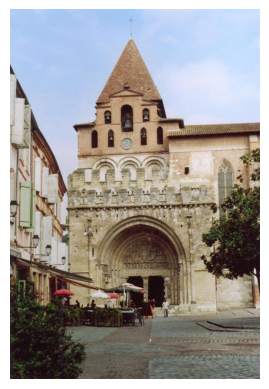

In [7]:
from PIL import Image
from matplotlib import pyplot as plt

img = Image.open("D:\\Download_In_D\\3D_Python\\Scene4\\Scene4_Main_Structure.jpg")
maxsize = (1600,900)

img.thumbnail(maxsize)
plt.axis('off')
plt.imshow(img)
plt.show()
img.save("D:\\Download_In_D\\3D_Python\\Scene4\\Scene4_Main_Structure_Thumbnailed.jpg")


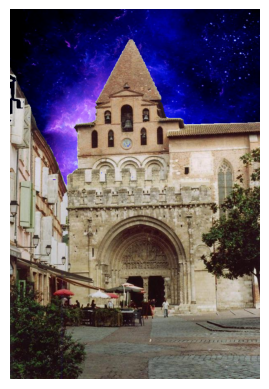

In [12]:
import cv2
import numpy as np

def define_replacement_area(image):
  mask = np.zeros_like(image)[:,:,0]   # Initialize mask, to cover only blue Sky area
  mask[image[:,:,0] > image[:,:,2]] = 1
  mask[image[:,:,0] > image[:,:,1]] += 1
  mask[350:,:100] = 0
  mask[450:,:] = 0

  return mask


original_image = cv2.imread('D:\\Download_In_D\\3D_Python\\Scene4\\Scene4_Main_Structure_Thumbnailed.jpg', cv2.IMREAD_COLOR)
replacement_image = cv2.imread('D:\\Download_In_D\\3D_Python\\Scene4\\Source\\HD-53.jpg', cv2.IMREAD_COLOR)
replacement_image = cv2.resize(replacement_image,(original_image.shape[1],original_image.shape[0]))


mask = define_replacement_area(original_image)
mask = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
modified_image = np.where(mask < (2), original_image, replacement_image)


image_rgb = cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB) #For plot visualize purpose only
plt.axis('off')
plt.imshow(image_rgb)
plt.show()

cv2.imwrite("D:\\Download_In_D\\3D_Python\\Scene4\\Modified_Image.jpg", modified_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


Main Class to call the 3D Object

-2.998990000000022 | -3.501990000000041, position: [  9.60037237   5.3158056   12.0857861  258.1       ]
-2.998990000000022 | -3.497990000000041, position: [  9.60037237   5.3158056   12.0857861  258.1       ]
-2.998990000000022 | -3.493990000000041, position: [  9.60037237   5.3158056   12.0857861  258.1       ]
-2.998990000000022 | -3.489990000000041, position: [  9.60037237   5.3158056   12.0857861  258.1       ]
-2.998990000000022 | -3.485990000000041, position: [  9.60037237   5.3158056   12.0857861  258.1       ]
-2.998990000000022 | -3.481990000000041, position: [  9.60037237   5.3158056   12.0857861  258.1       ]
-2.998990000000022 | -3.477990000000041, position: [  9.60037237   5.3158056   12.0857861  258.1       ]
-2.998990000000022 | -3.473990000000041, position: [  9.60037237   5.3158056   12.0857861  258.1       ]
-2.998990000000022 | -3.469990000000041, position: [  9.60037237   5.3158056   12.0857861  258.1       ]
-2.998990000000022 | -3.465990000000041, position: [  9

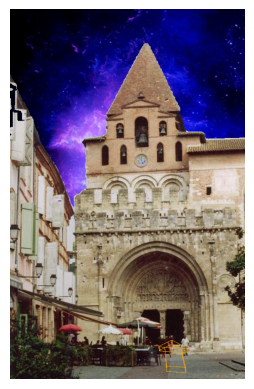

In [15]:
from object_3d import *
from camera import *
from projection import *
import pygame as pg
import os

img = pg.image.load("D:\\Download_In_D\\3D_Python\\Scene4\\Modified_Image.jpg")

resized_size = 1 #0.5
resized_image = pg.transform.scale(img, (img.get_width() * resized_size,img.get_height() * resized_size))


class SoftwareRender:
    def __init__(self):
        pg.init()
        self.RES = self.WIDTH, self.HEIGHT =  resized_image.get_width() - 100 , resized_image.get_height() - 100  #1600,900
        self.H_WIDTH, self.H_HEIGHT = self.WIDTH // 2, self.HEIGHT // 2
        self.FPS = 10
        self.create_objects()
        self.screen = pg.display.set_mode(self.RES) 
        self.clock = pg.time.Clock()



    def create_objects(self):
        self.camera = Camera(self, [0, 0, 0])
        self.projection = Projection(self)
        
        # ##### MOVING ARROW #####
        
        self.Start_angleYaw = -2.998990000000022
        self.Start_anglePitch = -3.505990000000041
        Start_Position = [9.60037237, 5.3158056, 12.0857861]
        
        self.Destination_angleYaw = -2.998990000000022
        self.Destination_anglePitch = -3.399490000000037

        
        self.object = self.get_object_from_file('D:\\Download_In_D\\3D_Python\\Software_3D_engine\\resources\\Arrow(1).obj') 
        self.camera.angleYaw = self.Start_angleYaw  #Initial X
        self.camera.anglePitch = self.Start_anglePitch   #Initial Y
        self.camera.position = np.array([*Start_Position, 258.1])
        
        StepsFromStartToEnd = 250
        self.Rotate_angleYaw =  1/StepsFromStartToEnd
        self.Rotate_anglePitch = (self.Destination_angleYaw / self.camera.angleYaw) /StepsFromStartToEnd
        
        
        self.reverse = False

        # ##### END MOVE LEFT RIGHT #####


    def get_object_from_file(self, filename):   
        vertex, faces = [], []
        with open(filename) as f:
            for line in f:
                if line.startswith('v '):
                    vertex.append([float(i) for i in line.split()[1:]] + [1])
                elif line.startswith('f'):
                    faces_ = line.split()[1:]
                    faces.append([int(face_.split('/')[0]) - 1 for face_ in faces_])
        return Object3D(self, vertex, faces)

    def draw(self):
        self.object.draw()

    def run(self):
        self.ImgCtr = 10 #start with 10 because of Python weird behaviour dealing with 0

        for ImgCtr in range(53):

            self.screen.fill((255, 255, 255))
            
            if (self.reverse == False ) and (self.camera.anglePitch <= self.Destination_anglePitch) :
                self.camera.anglePitch += self.Rotate_anglePitch
            else:
                self.reverse = True
                self.camera.anglePitch -= self.Rotate_anglePitch
                if self.camera.anglePitch <= self.Start_anglePitch:
                    self.reverse = False
            
            
            self.screen.blit(resized_image,  (0, 0))  # Input image as background
            pg.display.set_caption(str(self.camera.angleYaw) +" | "+ str(self.camera.anglePitch) + ", position: " + str(self.camera.position))
            print((str(self.camera.angleYaw) +" | "+ str(self.camera.anglePitch) + ", position: " + str(self.camera.position)))
            self.draw()
            pg.display.flip()
            
            ImgName = str(10+ImgCtr) + ".png"
            
            pg.image.save(self.screen, os.path.join("D:\\Download_In_D\\3D_Python\\Scene4\\Output\\SSForVideo_Arrow\\",ImgName))
        pg.display.quit()
        
        img = Image.open('D:\\Download_In_D\\3D_Python\\Scene4\\Output\\SSForVideo_Arrow\\54.png')
        plt.axis('off')
        plt.imshow(img)
        plt.show()
        

if __name__ == '__main__':
    app = SoftwareRender()
    app.run()

Start Video

In [9]:
import os
import cv2 
from PIL import Image

folder = ("D:\\Download_In_D\\3D_Python\\Scene4\\Output\\SSForVideo_Arrow\\")
saveName = "MovingArrow"
images = []

def create_video_from_images(folder):
    """Generate a video from all images in the specified folder."""
    video_filename = folder + '\\' + saveName + '.mp4'
    valid_images = [i for i in os.listdir(folder) if i.endswith((".jpg",".png"))]

    first_image = cv2.imread(os.path.join(folder, valid_images[0]))
    h, w, _ = first_image.shape

    codec = cv2.VideoWriter_fourcc(*'mp4v')
    vid_writer = cv2.VideoWriter(video_filename, codec, 120, (w, h))

    for img in valid_images:
        loaded_img = cv2.imread(os.path.join(folder, img))
        for _ in range(20):
            vid_writer.write(loaded_img)
        
        images.append(Image.open(os.path.join(folder, img)))
    images[0].save(folder + '\\' + saveName + '.gif' ,save_all = True, append_images = images[1:], optimize = False, duration = 60,loop = 0)    
    
    vid_writer.release()

create_video_from_images(folder) #Created Video and GIF

![SegmentLocal](\Output\SSForVideo_Arrow\MovingArrow.gif "segment")
